In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

In [2]:
rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)
jitter = 1e-8

# alpha means the sigma_y, noise for signal of objective value
gpr = GaussianProcessRegressor(kernel=rbf, alpha=jitter)

In [3]:
X_train = np.arange(-5,5,2.5).reshape(-1,1)
Y_train = np.sin(X_train) + jitter

In [4]:
X_true = np.linspace(-5,5,1000).reshape(-1,1)
Y_true = np.sin(X_true) + jitter

In [5]:
gpr.fit(X_train, Y_train)


GaussianProcessRegressor(alpha=1e-08, kernel=1**2 * RBF(length_scale=1))

In [6]:
X = np.arange(-5,5,0.2).reshape(-1,1)

In [7]:
# Computing posterior predictive mean and covariance
mu_s, cov_s = gpr.predict(X, return_cov = True)

# cov_s len(X) x len(X) matrix

# Diagonal factors should be zero or positive? because it means "Variance" of function value in that location

In [8]:
# Obtain optimized kernel parameters
l = gpr.kernel_.k2.get_params()['length_scale']
sigma_f = np.sqrt(gpr.kernel_.k1.get_params()["constant_value"])

In [9]:
import matplotlib.pyplot as plt
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov)) # Diagonal factors are variances of that location function value
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()

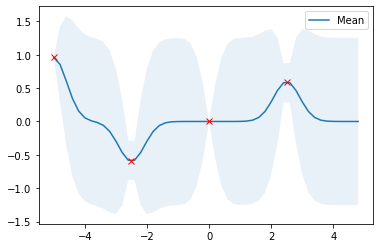

In [10]:
plot_gp(mu_s,cov_s, X, X_train=X_train, Y_train=Y_train)

In [11]:
import numpy as np

def kernel(X1, X2, l=1.0, sigma_f=1.0):
    '''
    Isotropic squared exponential kernel. Computes 
    a covariance matrix from points in X1 and X2.
        
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

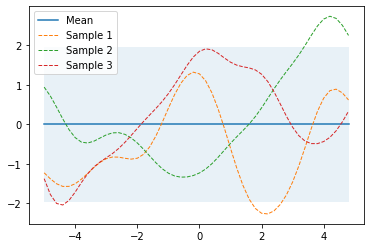

In [12]:
%matplotlib inline


# Finite number of points
X = np.arange(-5, 5, 0.2).reshape(-1, 1)

# Mean and covariance of the prior
mu = np.zeros(X.shape)
cov = kernel(X, X)

# Draw three samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)

# Plot GP mean, confidence interval and samples 
plot_gp(mu, cov, X, samples=samples)

In [13]:
from numpy.linalg import inv

def posterior_predictive(X_s, X_train, Y_train, l, sigma_f, sigma_y):
    '''  
    Computes the suffifient statistics of the GP posterior predictive distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    '''
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    # Equation (4)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    # Equation (5)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

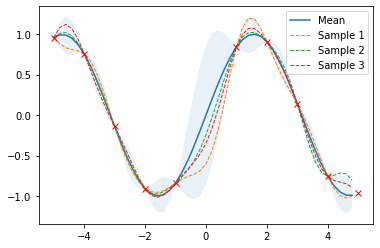

In [14]:
# Noise free training data
X_train = np.array([-5.0, -4.0, -3.0, -2.0,-1.0,1.0,2.0,3.0,4.0, 5.0]).reshape(-1, 1)
Y_train = np.sin(X_train)

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X, X_train, Y_train, l=1.0, sigma_f = 1.0, sigma_y = 0.001)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

In [15]:
X_train

array([[-5.],
       [-4.],
       [-3.],
       [-2.],
       [-1.],
       [ 1.],
       [ 2.],
       [ 3.],
       [ 4.],
       [ 5.]])

In [16]:
def delta_func(x):
    return np.greater(x , -0.5) * np.less(x, 0.5) * (-3)

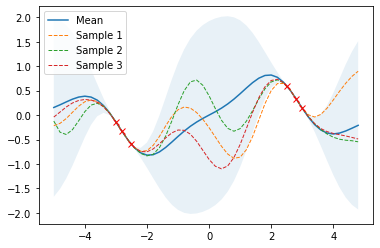

In [17]:
noise = 0.0001

# Noisy training data
#X_train = np.arange(-3, 2, 1.1).reshape(-1, 1)
X_train = np.array([-3.0, -2.8, -2.5,2.5,2.8,3.0]).reshape(-1, 1)

Y_train = np.sin(X_train) + delta_func(X_train)
#+ noise * np.random.randn(*X_train.shape)

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X, X_train, Y_train,l=1.0, sigma_f=1.0, sigma_y=noise)


samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

In [18]:
X_true = np.linspace(-5,5,1000).reshape(-1,1)
Y_true = np.sin(X_true) + delta_func(X_true)

In [26]:
from scipy.stats import norm

def expected_improvement(X, X_train, Y_train, length_scale, sigma_f, sigma_y, xi=0.2):
    mu_s, cov_s = posterior_predictive(X, X_train, Y_train, length_scale, sigma_f, sigma_y = sigma_y)
    
    mu_sample_opt = np.min(Y_train)
    sigma = np.sqrt(np.diag(cov_s))
    sigma = sigma.reshape(-1,1)
    
    with np.errstate(divide='warn'):
        imp = mu_sample_opt - mu_s - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma==0.0] = 0.0
        
    return ei

In [20]:
def plot_acquisition(X, Y, X_next, show_legend=False):
    plt.plot(X, Y, 'r-', lw=1, label='Acquisition function')
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    if show_legend:
        plt.legend()  

In [21]:
from scipy.optimize import minimize

def propose_location(acquisition, X_sample, Y_sample, length_scale, sigma_f, sigma_y, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.

    Returns:
        Location of the acquisition function maximum.
    '''
    dim = X_sample.shape[1]
    
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, length_scale, sigma_f, sigma_y).ravel()
    
    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
        if res.fun < min_val:
            min_val = res.fun[0]
            min_x = res.x           
            
    return min_x.reshape(-1, 1)

[[-2.38165997]]
[[-2.07363137]]
[[-1.75162748]]
[[-1.39250053]]
[[-1.43276019]]
[[-1.64785015]]


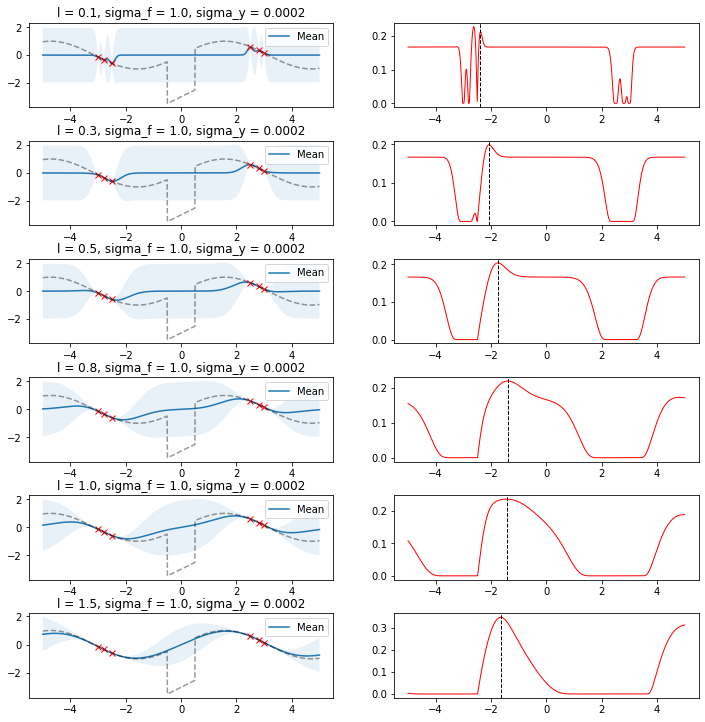

In [22]:
import matplotlib.pyplot as plt

params = [
    (0.1, 1.0, 0.0002),
    (0.3, 1.0, 0.0002),
    (0.5, 1.0, 0.0002),
    (0.8, 1.0, 0.0002),
    (1.0, 1.0, 0.0002),
    (1.5, 1.0, 0.0002),
]
bounds = np.array([[-5.0,5.0]])
plt.figure(figsize=(12, 5))
plt.subplots_adjust(hspace=0.4)

for i, (l, sigma_f, sigma_y) in enumerate(params):
    mu_s, cov_s = posterior_predictive(X_true, X_train, Y_train, l=l, 
                                       sigma_f=sigma_f, 
                                       sigma_y=sigma_y)
    mu_sample_opt = np.max(Y_train)
    plt.subplot(len(params), 2, 2*i + 1)
    plt.subplots_adjust(top=2)
    plt.title(f'l = {l}, sigma_f = {sigma_f}, sigma_y = {sigma_y}')
    plot_gp(mu_s, cov_s, X_true, X_train=X_train, Y_train=Y_train)
    plt.plot(X_true, Y_true,linestyle = '--' ,color='k', alpha = 0.4)
    
    X_next = propose_location(expected_improvement, X_train, Y_train, l, sigma_f, sigma_y, bounds)
    print(X_next)
    plt.subplot(len(params), 2, 2*i + 2)
    #expected_improvement(X_true, X_train, Y_train, 1, 1, 0.0001)
    plot_acquisition(X_true, expected_improvement(X_true, X_train, Y_train, l,sigma_f,sigma_y), X_next)
    

In [23]:
-expected_improvement(X, X_train,Y_train, l, sigma_f, sigma_y).ravel()

array([-3.02307986e-003, -6.31408345e-004, -5.68304620e-005,
       -1.08466972e-006, -8.85250502e-010, -5.10059236e-016,
       -7.97748325e-031, -3.05374555e-075, -2.65938691e-271,
       -0.00000000e+000, -0.00000000e+000, -0.00000000e+000,
       -0.00000000e+000, -6.57558731e-002, -1.93266560e-001,
       -2.84121829e-001, -3.34968734e-001, -3.45318421e-001,
       -3.21653137e-001, -2.80233965e-001, -2.34996208e-001,
       -1.91614855e-001, -1.51124147e-001, -1.13466023e-001,
       -7.90609587e-002, -4.92022811e-002, -2.57578905e-002,
       -1.02631791e-002, -2.60087341e-003, -2.96007492e-004,
       -7.26149079e-006, -6.95684941e-009, -2.95851759e-015,
       -6.46967829e-031, -3.24436699e-078, -1.49937563e-272,
       -0.00000000e+000, -0.00000000e+000, -0.00000000e+000,
       -0.00000000e+000, -0.00000000e+000, -0.00000000e+000,
       -4.56004577e-054, -4.00852042e-006, -2.09815456e-002,
       -1.01794745e-001, -1.82098952e-001, -2.42019672e-001,
       -2.81168950e-001,

[[-2.37193879]]
[[-2.04305239]]
[[-1.68829933]]
[[-1.22583824]]
[[-1.01785253]]
[[5.]]


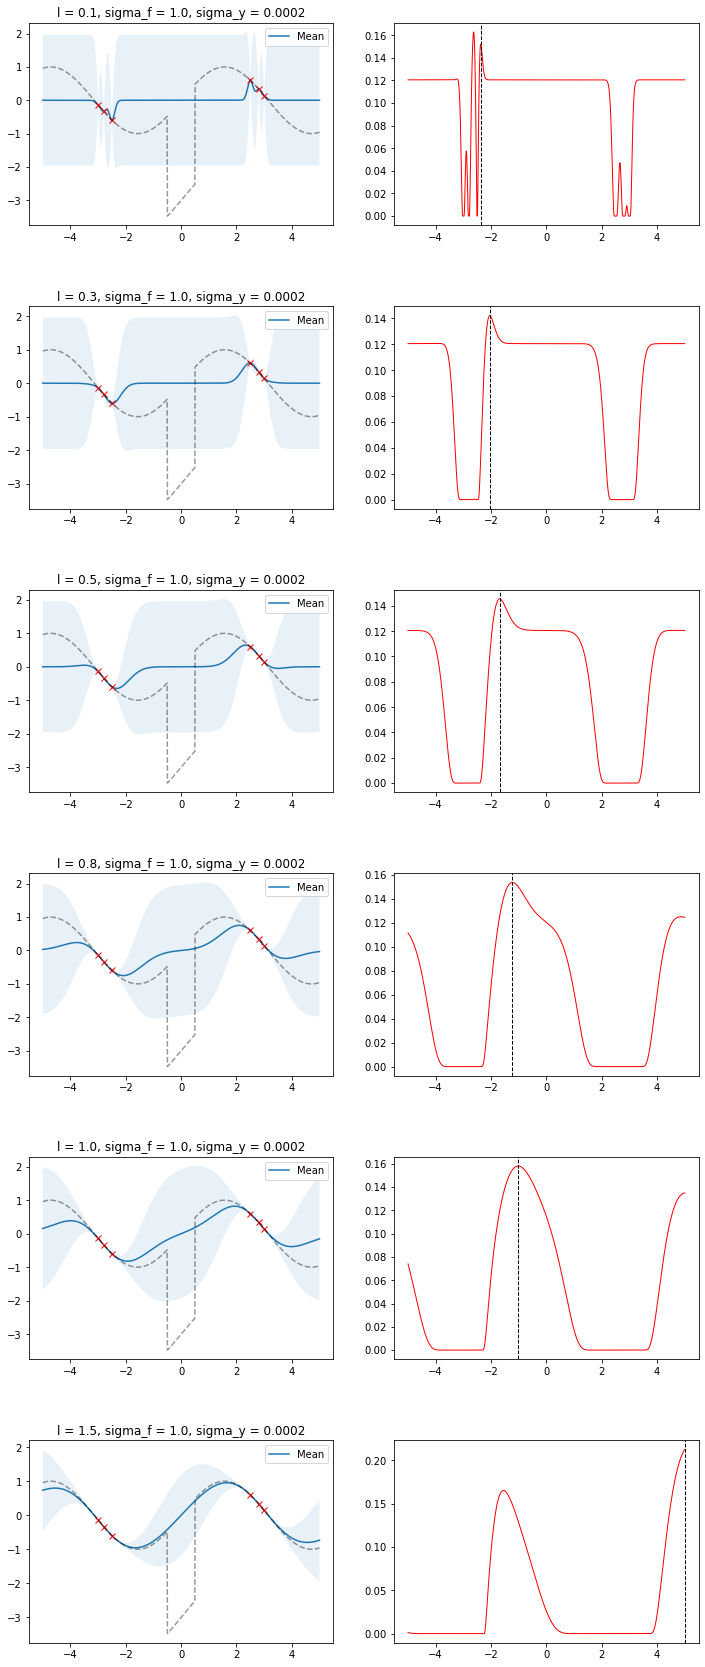

In [30]:
import matplotlib.pyplot as plt

params = [
    (0.1, 1.0, 0.0002),
    (0.3, 1.0, 0.0002),
    (0.5, 1.0, 0.0002),
    (0.8, 1.0, 0.0002),
    (1.0, 1.0, 0.0002),
    (1.5, 1.0, 0.0002),
]
bounds = np.array([[-5.0,5.0]])
plt.figure(figsize=(12, 12))
plt.subplots_adjust(hspace=0.4)

for i, (l, sigma_f, sigma_y) in enumerate(params):
    mu_s, cov_s = posterior_predictive(X_true, X_train, Y_train, l=l, 
                                       sigma_f=sigma_f, 
                                       sigma_y=sigma_y)
    mu_sample_opt = np.max(Y_train)
    plt.subplot(len(params), 2, 2*i + 1)
    plt.subplots_adjust(top=2)
    plt.title(f'l = {l}, sigma_f = {sigma_f}, sigma_y = {sigma_y}')
    plot_gp(mu_s, cov_s, X_true, X_train=X_train, Y_train=Y_train)
    plt.plot(X_true, Y_true,linestyle = '--' ,color='k', alpha = 0.4)
    
    X_next = propose_location(expected_improvement, X_train, Y_train, l, sigma_f, sigma_y, bounds)
    print(X_next)
    plt.subplot(len(params), 2, 2*i + 2)
    #expected_improvement(X_true, X_train, Y_train, 1, 1, 0.0001)
    plot_acquisition(X_true, expected_improvement(X_true, X_train, Y_train, l,sigma_f,sigma_y), X_next)
    

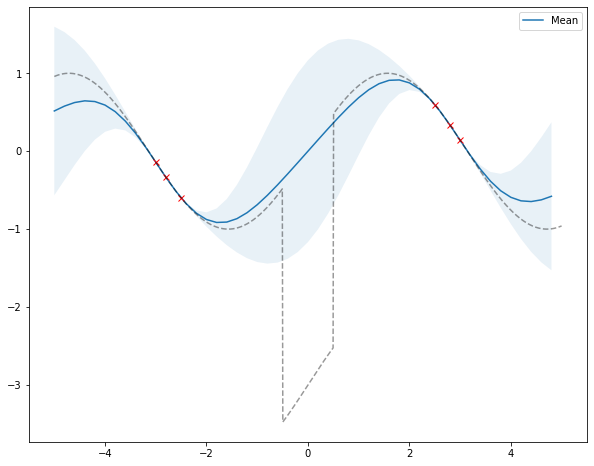

In [34]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

rbf = ConstantKernel(1.0) * RBF(length_scale=0.5)
gpr = GaussianProcessRegressor(kernel=rbf, alpha=0.0002**2)

# Reuse training data from previous 1D example
gpr.fit(X_train, Y_train)

# Compute posterior predictive mean and covariance
mu_s, cov_s = gpr.predict(X, return_cov=True)

# Obtain optimized kernel parameters
l = gpr.kernel_.k2.get_params()['length_scale']
sigma_f = np.sqrt(gpr.kernel_.k1.get_params()['constant_value'])

# Plot the results
plt.figure(figsize=(10,8))
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)
plt.plot(X_true, Y_true,linestyle = '--' ,color='k', alpha = 0.4)

In [35]:
print(l, sigma_f)

1.3214351419928192 0.7548975088252311


In [36]:
l

1.3214351419928192

In [37]:
sigma_f

0.7548975088252311